In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
import os
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap
# Make sure that caffe is on the python path:
caffe_root = '/home/lli-ms/caffe/'
pretrained_model_root = '/home/lli-ms/caffe/'

# run this line one time only!
import sys
caffePython = pretrained_model_root + 'python'
if caffePython not in sys.path:
    sys.path.insert(0, caffePython)

import caffe
# Load mean
mu = np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print 'mean-subtracted values:', zip('BGR', mu)

MODEL_FILE = '../neuralNet/VGG16/vgg16_attr_deploy.prototxt'
PRETRAINED_FILE = caffe_root + 'models/vgg16_attr/snapshots/first_train_iter_2000.caffemodel'
PRETRAINED_FILE = caffe_root + 'models/VGG16/VGG_ILSVRC_16_layers.caffemodel'
caffe.set_device(1)
caffe.set_mode_gpu()
if not os.path.isfile(PRETRAINED_FILE):
    print("No caffemodel!!!")
elif not os.path.isfile(MODEL_FILE):
    print("No MODEL !!!")
else:
    print "Defining the net!"
    net = caffe.Net(MODEL_FILE,
                PRETRAINED_FILE,
                caffe.TEST)
# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_mean('data', mu)
for layer_name, param in net.params.iteritems():
    print layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape)
transformer.set_transpose('data', (2,0,1))
# the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_raw_scale('data', 255) 
# the reference model has channels in BGR order instead of RGB
transformer.set_channel_swap('data', (2,1,0))

mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]
Defining the net!
conv1_1	(64, 3, 3, 3) (64,)
conv1_2	(64, 64, 3, 3) (64,)
conv2_1	(128, 64, 3, 3) (128,)
conv2_2	(128, 128, 3, 3) (128,)
conv3_1	(256, 128, 3, 3) (256,)
conv3_2	(256, 256, 3, 3) (256,)
conv3_3	(256, 256, 3, 3) (256,)
conv4_1	(512, 256, 3, 3) (512,)
conv4_2	(512, 512, 3, 3) (512,)
conv4_3	(512, 512, 3, 3) (512,)
conv5_1	(512, 512, 3, 3) (512,)
conv5_2	(512, 512, 3, 3) (512,)
fc_pca	(255, 100352) (255,)
fc_out	(1, 255) (1,)


In [12]:
import cv2
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) /data.max()*255
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    data = cv2.cvtColor(data,cv2.COLOR_GRAY2RGB)
    print data.shape
    plt.imshow(data); plt.axis('off')

In [13]:
fileName = '/home/lli-ms/attractiveness_datamining/MIT2kFaceDataset/2kfaces/wilma-1_oval.jpg'
(filename, ext) = fileName.split(".")
imgeReshape = [224,224]
input_image = caffe.io.load_image(fileName)
net.blobs['data'].reshape(1,3,imgeReshape[0],imgeReshape[1])
net.blobs['data'].data[...] = transformer.preprocess('data', input_image)
net.forward()

{'fc_out': array([[ 0.]], dtype=float32)}

(64, 14, 14)
(120, 120, 3)


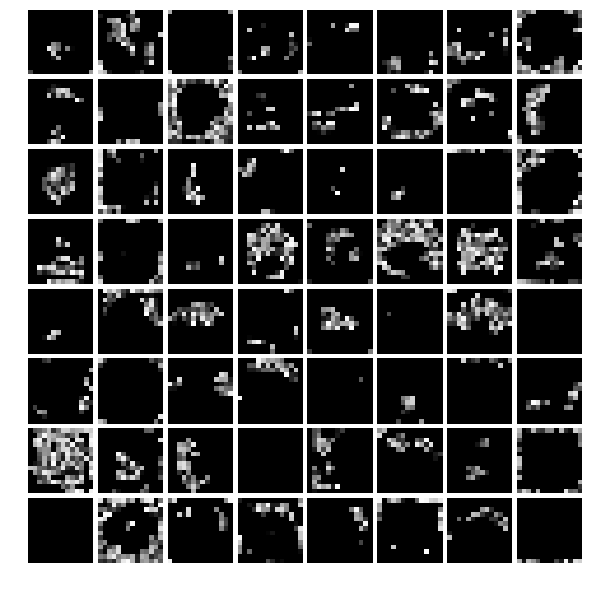

In [14]:
feat = net.blobs['conv5_2'].data[0, :64]
print feat.shape
vis_square(feat)


(64, 64, 3, 3)
0.289171
-0.215613


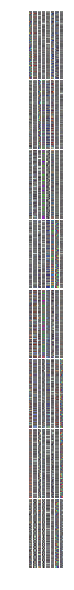

In [166]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1_2'][0].data
print filters.shape
print np.max(filters)
print np.min(filters)
filters_sample = filters[:,:,:,:]
plt.rcParams['figure.figsize'] = (10, 10)  
vis_square(filters_sample)#.transpose(0, 2, 3, 1))

In [11]:
filters = net.params['conv1_1'][0].data
filters.shape

(64, 3, 3, 3)

In [154]:
import cv2
import Image
layers = list(net.params.keys())

In [96]:
# extract the filename and extension of the input image


# loop over the layers
for (i, layer) in enumerate(layers):
    # perform visualizing using the current layer
    print("[INFO] processing layer `{}` {}/{}".format(layer, i + 1, len(layers)))
 
    try:# pass the image through the network
        image = net.forward(end=layer)
        image = image.values()[0][0]
        print image.shape
        # draw the layer name on the image
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        cv2.putText(image, layer, (5, image.shape[0] - 10),\
                    cv2.FONT_HERSHEY_SIMPLEX, 0.95, (0, 255, 0), 2)
        # construct the output path and write the image to file
        p = "{}/{}_{}.{}".format(args.output, filename, str(i + 1).zfill(4), ext)
        cv2.imwrite(p, image)
 
    except KeyError, e:
        # the current layer can not be used
        
        print("[ERROR] cannot use layer `{}`".format(layer))

[INFO] processing layer `conv1_1` 1/14
(64, 224, 224)


error: /home/yshu-phd/opencv/modules/imgproc/src/color.cpp:8405: error: (-215) scn == 3 || scn == 4 in function cvtColor
